In [44]:
import torch
from torch import nn 
import torchvision
from torchvision import transforms,datasets
import pathlib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
data_dir = pathlib.Path('./49-data')

In [17]:
class_names = [i.name for i in list(data_dir.glob("*"))]

In [22]:
train_transforms = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225])
])

In [35]:
total_data = datasets.ImageFolder('./49-data',transform=train_transforms)

In [36]:
total_data.class_to_idx

{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

In [37]:
len(total_data.imgs)

1200

In [40]:
train_size = int(0.8*len(total_data.imgs))
test_size = len(total_data.imgs) - train_size
train_dataset,test_dataset = torch.utils.data.random_split(total_data,[train_size,test_size]) # 这里其实是构造了dataset

In [41]:
train_dataset.dataset

Dataset ImageFolder
    Number of datapoints: 1200
    Root location: ./49-data
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [42]:
batch_size = 32
train_dl = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=1)
test_dl = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,num_workers=1)

In [43]:
for X, y in test_dl:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 224, 224])
Shape of y:  torch.Size([32]) torch.int64


In [53]:
import torch.nn.functional as F

class vgg16(nn.Module):
    def __init__(self):
        super(vgg16, self).__init__()
        # 卷积块1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        # 卷积块2
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        # 卷积块3
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        # 卷积块4
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        # 卷积块5
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        
        # 全连接网络层，用于分类
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4)
        )

    def forward(self, x):

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)

        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
    
model = vgg16().to(device)
model

Using cuda device


vgg16(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, cei

In [54]:
# 统计模型参数量以及其他指标
import torchsummary as summary
summary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [55]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小
    num_batches = len(dataloader)   # 批次数目, (size/batch_size，向上取整)

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [56]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小
    num_batches = len(dataloader)          # 批次数目, (size/batch_size，向上取整)
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [58]:
import copy

optimizer  = torch.optim.Adam(model.parameters(), lr= 1e-4)
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数

epochs     = 40

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

best_acc = 0    # 设置一个最佳准确率，作为最佳模型的判别指标

for epoch in range(epochs):
    
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, optimizer)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    # 保存最佳模型到 best_model
    if epoch_test_acc > best_acc:
        best_acc   = epoch_test_acc
        best_model = copy.deepcopy(model)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    # 获取当前的学习率
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%, Test_loss:{:.3f}, Lr:{:.2E}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, 
                          epoch_test_acc*100, epoch_test_loss, lr))
    
# 保存最佳模型到文件中
PATH = './best_model.pth'  # 保存的参数文件名
torch.save(model.state_dict(), PATH)

print('Done')

Epoch: 1, Train_acc:23.5%, Train_loss:1.388, Test_acc:23.8%, Test_loss:1.386, Lr:1.00E-04
Epoch: 2, Train_acc:22.8%, Train_loss:1.387, Test_acc:23.8%, Test_loss:1.386, Lr:1.00E-04
Epoch: 3, Train_acc:31.7%, Train_loss:1.330, Test_acc:43.8%, Test_loss:1.142, Lr:1.00E-04
Epoch: 4, Train_acc:62.2%, Train_loss:0.790, Test_acc:70.4%, Test_loss:0.659, Lr:1.00E-04
Epoch: 5, Train_acc:73.9%, Train_loss:0.583, Test_acc:78.8%, Test_loss:0.490, Lr:1.00E-04
Epoch: 6, Train_acc:84.5%, Train_loss:0.445, Test_acc:78.3%, Test_loss:0.465, Lr:1.00E-04
Epoch: 7, Train_acc:86.6%, Train_loss:0.364, Test_acc:90.8%, Test_loss:0.268, Lr:1.00E-04
Epoch: 8, Train_acc:93.1%, Train_loss:0.211, Test_acc:95.4%, Test_loss:0.154, Lr:1.00E-04
Epoch: 9, Train_acc:93.9%, Train_loss:0.146, Test_acc:97.9%, Test_loss:0.085, Lr:1.00E-04
Epoch:10, Train_acc:97.0%, Train_loss:0.084, Test_acc:92.1%, Test_loss:0.210, Lr:1.00E-04
Epoch:11, Train_acc:93.1%, Train_loss:0.172, Test_acc:82.9%, Test_loss:0.443, Lr:1.00E-04
Epoch:12, 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


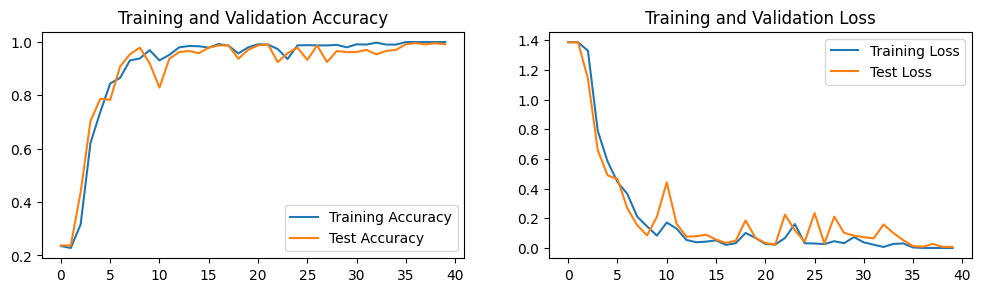

In [59]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
from PIL import Image 

classes = list(total_data.class_to_idx)

def predict_one_image(image_path, model, transform, classes):
    
    test_img = Image.open(image_path).convert('RGB')
    plt.imshow(test_img)  # 展示预测的图片

    test_img = transform(test_img)
    img = test_img.to(device).unsqueeze(0)
    
    model.eval()
    output = model(img)

    _,pred = torch.max(output,1)
    pred_class = classes[pred]
    print(f'预测结果是：{pred_class}')

预测结果是：Dark


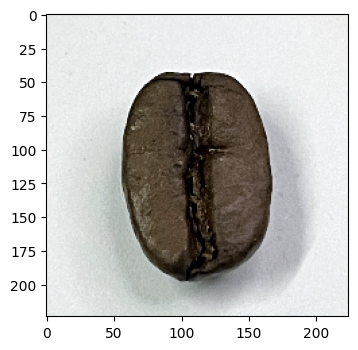

In [62]:
# 预测训练集中的某张照片
predict_one_image(image_path='./49-data/Dark/dark (1).png', 
                  model=model, 
                  transform=train_transforms, 
                  classes=classes)

In [63]:
best_model.eval()
epoch_test_acc, epoch_test_loss = test(test_dl, best_model, loss_fn)

In [64]:
epoch_test_acc, epoch_test_loss

(0.9958333333333333, 0.009317589971260531)